# Information leakage analysis framework

The following is a framework for the comprehensive analysis of information leakage.

## Initialization

#### Import modules

In [586]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,  mutual_info_score, precision_recall_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.inference.attribute_inference import AttributeInferenceBaseline
from art.attacks.inference.attribute_inference import AttributeInferenceBlackBox
from scipy.stats import entropy
import matplotlib.pyplot as plt

#### Parameter configuration

Simply enter desired values or keep defaults and press run all. 

In [587]:
"""PREPROCESSING SETTINGS"""
PATH_TO_MOVIELENS = "./ml-100k"
DATASET_SIZE_LIMIT = 10000 # Numbers above full size are duplicated
PRINT_MOVIELENS = True # Prints the dataframe to confirm successful load
FEATURES_TO_REMOVE = ['movie_title', 'timestamp', 'imdb_url', 'release_date', 'video_release_date', 'zip_code', 'occupation_text']
TARGET_FEATURE = 'gender' #gender
FEATURES_TO_ENCODE = ['movie_id', 'user_id', 'gender', 'occupation_label']
PRINT_MOVIELENS_PREPROCESSED = True
CALCULATE_MI_ALL_FEATURE_COMBINATIONS = False # Computationally expensive, calc mutual info for all features
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.5
SEED = 41 # Random seed for shuffling 

"""BASE MODEL SETTINGS"""
# binary_crossentropy, categorical_crossentropy, sparse_categorical_crossentropy, 
# mean_squared_error, mean_absolute_error, hinge, squared_hinge, categorical_hinge, log_cosh, huber
LOSS_NAME = 'binary_crossentropy' #'sparse_categorical_crossentropy' # 
OPTIMIZER_NAME = 'SGD'# SGD, Adam, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
REGULARIZER_NAME = 'l1' # l1, l2, l1_l2
LEARNING_RATE = 0.01
REGULARIZATION_FACTOR = 0.01
ACTIVATION_FUNCTION = 'softmax' #'sigmoid' #'softmax' # relu, sigmoid, softmax, softplus, softsign, tanh, selu, elu, exponential
MIDDLE_LAYER_ACTIVATION_FUNCTION = 'relu'
MIDDLE_LAYER_NEURONS = 96

"""MODEL TRAINING SETTINGS"""
EPOCHS= 5
PATIENCE = 3 # Number of epochs to wait for validation accuracy improvement before stopping
SHUFFLE=True # Shuffle the data after each epoch a measure to counter overfitting to acute patterns within the datastream.
SHUFFLE_BUFFER_SIZE = 10000 # Buffer size for shuffling, the greater the better but more memory intensive
BATCH_SIZE = 200 # Number of samples to use in each training step, model is online if BATCH_SIZE = 1 and offline if BATCH_SIZE = DATASET_SIZE_LIMIT

"""MODEL METRICS"""
# 'accuracy', 'validation_accuracy', 'loss', 'precision', 'recall', 'f1_score', 'confusion_matrix'
BASE_METRICS = ['accuracy', 'validation_accuracy', 'loss', 'precision', 'recall', 'f1_score']
PLOT_METRICS = True
PLOT_SAVE_PATH = './plots/'
PRECISION_AVERAGE = 'weighted' #micro, macro, weighted
RECALL_AVERAGE = 'weighted'
F1_AVERAGE = 'weighted'
MODEL_NAME = f'{TARGET_FEATURE.capitalize()} Model'
PRINT_METRICS_EVERY_X_STEPS = 100 # How many steps before checking metrics, low values may cause slowdown
SIGNIFICANT_FIGURES = 4 # Number of significant figures to display in metrics (both base and attack)

"""ATTACK SETTINGS"""
ATTACK_TEST_SPLIT = 0.5
ATTACK_TARGET_FEATURE = 'occupation_label' # The feature to attack must be different from the original model

"""DIFFERENTIAL PRIVACY SETTINGS"""
EPSILON=1 # Tradeoff between security and utility
APPLY_DP_TO_BASE_INPUT=False
APPLY_DP_TO_BB_INPUT=True
APPLY_DP_TO_BASE_PREDICTIONS=False
DP_MECHANISM = 'laplace' #laplace, exponential


## Differential Privacy Mechanisms

### Information Metrics Definition

In [588]:
def calculate_entropy(data, bins=None):
    if bins is not None:
        data = np.digitize(data, bins)
    _, counts = np.unique(data, return_counts=True)
    probabilities = counts / len(data)
    return entropy(probabilities)

def calculate_mutual_info(true_values, inferred_values):
    mutual_info = mutual_info_score(true_values, inferred_values)
    return mutual_info

### Laplacian Noise

In [589]:
def laplace_mechanism(data):
    # Calculate the sensitivity of the data
    sensitivity = np.max(data) - np.min(data)

    # Generate noise
    noise = np.random.laplace(loc=0, scale=sensitivity/EPSILON, size=data.shape)

    # Add the noise to the data
    noisy_data = data + noise

    # Round the noisy data to the nearest integer within the range of the original data
    noisy_data = np.round(noisy_data).clip(np.min(data), np.max(data))

    return noisy_data

### Exponential noise

In [590]:
def exponential_mechanism(data):
    # Utility function that favors the highest class
    preferred_class = np.max(data)
    # If all elements in x should match preferred_class
    utility_function = lambda x: 1 if np.array_equal(x, preferred_class) else 0

    # If any element in x should match preferred_class
    utility_function = lambda x: 1 if np.any(x == preferred_class) else 0
    
    utilities = np.array([utility_function(d) for d in data])
    
    # Calculate the probabilities for each data point
    probabilities = np.exp(EPSILON * utilities / 2)
    probabilities /= np.sum(probabilities)

    if len(probabilities) != len(data):
        probabilities = np.ones_like(data) / len(data)

    private_data = np.random.choice(data.flatten(), p=probabilities.flatten())
    private_data = np.random.choice(data, p=probabilities)
    
    return private_data



### Apply DP method

In [591]:
def apply_dp(target):
    if(DP_MECHANISM=='laplace'):
        return laplace_mechanism(target)
    elif(DP_MECHANISM=='exponential'):
        return exponential_mechanism(target)
    else:
        raise ValueError(f"Invalid DP mechanism: {DP_MECHANISM} not recognised")

## Preprocessing

#### Load Movielens Dataset

Loads the full Movielens dataset into pandas dataframes from the path configured in parameters. Has to be manually modified for alternative datasets

In [592]:
# Generate all file paths 
path = PATH_TO_MOVIELENS

data_path = path + "/u.data"
genre_path = path + "/u.genre"
item_path = path + "/u.item"
occupation_path = path + "/u.occupation"
user_path = path + "/u.user"

# Load data into pandas dataframes
rating_columns = ["user_id", "movie_id", "user_rating", "timestamp"]
rating_df = pd.read_csv(data_path, sep="\t", header=None, names=rating_columns)

genre_df = pd.read_csv(genre_path, sep="|", header=None, names=["genre_id", "genre_name"])
item_columns = ["movie_id", "movie_title", "release_date", "video_release_date", "imdb_url"] + \
                [f"genre_{i}" for i in range(1, 20)]
item_df = pd.read_csv(item_path, sep="|", encoding="latin-1", header=None, names=item_columns)

occupation_df = pd.read_csv(occupation_path, sep="|", header=None, names=["occupation"])

user_columns = ["user_id", "age", "gender", "occupation_label", "occupation_text", "zip_code"]
user_df = pd.read_csv(user_path, sep="|", header=None, names=user_columns)

# Merge the required dataframes containing chosen features, needs to be modified if other datasets are used
# TODO: Must be adapted for other datasets
merged_df_part = pd.merge(rating_df, item_df, on='movie_id', how='inner')
merged_df = pd.merge(user_df, merged_df_part, on='user_id', how='inner')

#### Print dataframe (sanity check)

In [593]:
if(PRINT_MOVIELENS):
    print("Rating dataframe:")
    print(rating_df.head(1))
    print("\nGenre dataframe:")
    print(genre_df.head(1))
    print("\nItem dataframe:")
    print(item_df.head(1))
    print("\nOccupation dataframe:")
    print(occupation_df.head(1))
    print("\nUser dataframe:")
    print(user_df.head(1))
    

Rating dataframe:
   user_id  movie_id  user_rating  timestamp
0      196       242            3  881250949

Genre dataframe:
  genre_id  genre_name
0  unknown           0

Item dataframe:
   movie_id       movie_title release_date  video_release_date  \
0         1  Toy Story (1995)  01-Jan-1995                 NaN   

                                            imdb_url  genre_1  genre_2  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0        0   

   genre_3  genre_4  genre_5  ...  genre_10  genre_11  genre_12  genre_13  \
0        0        1        1  ...         0         0         0         0   

   genre_14  genre_15  genre_16  genre_17  genre_18  genre_19  
0         0         0         0         0         0         0  

[1 rows x 24 columns]

Occupation dataframe:
      occupation
0  administrator

User dataframe:
   user_id  age gender occupation_label occupation_text  zip_code
0        1   24      M       technician           85711       NaN


#### Encode categorical features

In [594]:
# TODO: Must be adapted for other datasets
# Manually encode age and rating into 4 categories
age_range = [0, 17, 36, 50, np.inf]
age_labels = [0, 1, 2, 3]
merged_df['age'] = pd.cut(merged_df['age'], bins=age_range, labels=age_labels)
merged_df['user_rating'] = merged_df['user_rating'] - 1

# Encode categorical columns
encoders = {f: LabelEncoder() for f in FEATURES_TO_ENCODE}
for feature in encoders:
    merged_df[feature] = encoders[feature].fit_transform(merged_df[feature])

# Reverse encoding
def inverse_transformation(target, target_feature):
    if isinstance(target, pd.DataFrame):
        target = target.values
        
    if target_feature == 'age':
        age_map = {0:1, 1: 18, 2:37, 3:51}
        vfunc = np.vectorize(age_map.get)
        target = vfunc(target)
    elif target_feature == 'user_rating':
        target = target + 1
    else:
        target = encoders[target_feature].inverse_transform(target)

    return target

#### Remove features and split data

In [595]:
# Check if the columns exist in the dataframe before dropping them
for feature in FEATURES_TO_REMOVE:
    if feature in merged_df.columns:
        merged_df = merged_df.drop(feature, axis=1)

# Randomly sample a smaller dataset
merged_df = merged_df.sample(n=DATASET_SIZE_LIMIT, replace=True, random_state=SEED)


# Remove the target feature
x = merged_df.drop(TARGET_FEATURE, axis=1).values
x_df = merged_df.drop(TARGET_FEATURE, axis=1)
y = merged_df[TARGET_FEATURE].values

# Split the data into a training, testing and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=TEST_SPLIT, random_state=SEED)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=VALIDATION_SPLIT, random_state=SEED)

#### Print processed dataframe (sanity check)

In [596]:
if(PRINT_MOVIELENS_PREPROCESSED):
    print(merged_df.head())

       user_id age  gender  occupation_label  movie_id  user_rating  genre_1  \
34752      320   2       0                 3       132            4        0   
931          6   3       1                 0       206            3        0   
61324      541   1       1                18       131            2        0   
85986      803   2       1                 3       707            2        0   
53491      472   1       1                18      1141            4        0   

       genre_2  genre_3  genre_4  ...  genre_10  genre_11  genre_12  genre_13  \
34752        0        0        0  ...         0         0         0         0   
931          1        0        0  ...         0         0         0         0   
61324        0        1        0  ...         0         0         0         1   
85986        0        0        0  ...         0         0         0         0   
53491        0        0        0  ...         0         0         0         0   

       genre_14  genre_15  genre

#### Feature selection by mutual information

##### Calculate mutual info for each feature combination, to identify promising feature pairs

In [597]:
def compute_mutual_info_all(df):
    mi_scores = {}
    features = df.columns
    for feature1 in features:
        for feature2 in features:
            if feature1 != feature2:
                mi = mutual_info_classif(df[[feature1]], df[feature2])
                mi_scores[(feature1, feature2)] = mi[0]
    return mi_scores

def compute_mutual_info_target(df):
    mi_scores = {}
    features = [f for f in df.columns if f != TARGET_FEATURE]
    for feature in features:
        mi = mutual_info_classif(df[[feature]], df[TARGET_FEATURE])
        mi_scores[feature] = mi[0]
    return mi_scores


##### Calculate and process all feature combinations

WARNING this is a pretty heavy computationally function, it may freeze your jupyter instance

In [598]:
if(CALCULATE_MI_ALL_FEATURE_COMBINATIONS):
    mi_scores_all = compute_mutual_info_all(merged_df)
    
    # Convert the dictionary to a DataFrame
    mi_scores_df = pd.DataFrame(list(mi_scores_all.items()), columns=['Features', 'Mutual Information'])

    # Split the tuple of features into two separate columns
    mi_scores_df[['Feature1', 'Feature2']] = pd.DataFrame(mi_scores_df['Features'].tolist(), index=mi_scores_df.index)

    # Drop the original 'Features' column
    mi_scores_df = mi_scores_df.drop('Features', axis=1)

    # Reorder the columns
    mi_scores_df = mi_scores_df[['Feature1', 'Feature2', 'Mutual Information']]

    # Sort the DataFrame by 'Mutual Information' in descending order
    mi_scores_df = mi_scores_df.sort_values('Mutual Information', ascending=False)

    # Filter out rows where 'Feature1' or 'Feature2' is 'user_id' or 'movie_id'
    mi_scores_df = mi_scores_df[~((mi_scores_df['Feature1'].isin(['user_id', 'movie_id'])) | (mi_scores_df['Feature2'].isin(['user_id', 'movie_id'])))]

    print(mi_scores_df.head(20))

## Plot definitions

### Training Metric Plots

In [599]:
def plot_metrics(metrics_dict, save_path=PLOT_SAVE_PATH):
    COLORS = ['b', 'g', 'r' , 'c', 'm', 'y', 'k']  # colors for the plots
    metrics_to_plot = BASE_METRICS.copy()

    # Remove 'confusion_matrix' from the list of metrics to plot
    if 'confusion_matrix' in metrics_to_plot:
        metrics_to_plot.remove('confusion_matrix')

    # Plot precision, recall, and f1_score together if they are available
    if 'precision' in BASE_METRICS and 'recall' in BASE_METRICS:
        metrics_to_plot.remove('precision')
        metrics_to_plot.remove('recall')
        precision = np.array(metrics_dict.get('precision', []))
        recall = np.array(metrics_dict.get('recall', []))
        plt.figure() 
        plt.plot(precision, label='Precision', color=COLORS[0])
        plt.plot(recall, label='Recall', color=COLORS[1])
        if 'f1_score' in BASE_METRICS:
            f1_score = np.array(metrics_dict.get('f1_score', []))
            plt.plot(f1_score, label='F1 Score', color=COLORS[2])
            metrics_to_plot.remove('f1_score')
        plt.title(f'{MODEL_NAME} PRF')
        plt.ylabel('Score')
        plt.xlabel('Batch')
        plt.legend()
        plt.grid(True)
        if save_path:
            plt.savefig(save_path+f'{TARGET_FEATURE}_PRF.png')
        plt.show() 

    # Plot accuracy and validation accuracy together if they are available
    if 'accuracy' in metrics_to_plot and 'validation_accuracy' in metrics_to_plot:
        metrics_to_plot.remove('accuracy')
        metrics_to_plot.remove('validation_accuracy')
        accuracy = np.array(metrics_dict.get('accuracy', []))
        val_accuracy = np.array(metrics_dict.get('validation_accuracy', []))
        plt.figure()  # create a new figure
        plt.plot(accuracy, label='Accuracy', color=COLORS[0])
        plt.plot(val_accuracy, label='Validation Accuracy', color=COLORS[1])
        plt.title(f'{MODEL_NAME} Accuracy')
        plt.ylabel('Decimal accuracy')
        plt.xlabel('Batch')
        plt.legend()
        plt.grid(True)
        if save_path:
            plt.savefig(save_path+f'{TARGET_FEATURE}_Accuracy.png')
        plt.show()  

    for i, (metric_name, metric_values) in enumerate(metrics_dict.items()):
        # Skip if the metric is a confusion matrix, 'validation_accuracy', or one of ['precision', 'recall', 'f1_score']
        if metric_name not in metrics_to_plot:
            continue
        try:
            metric_values = np.array(metric_values)
            # If metric_values is 2D, compute the mean across the second dimension
            if len(metric_values.shape) == 2:
                metric_values = np.mean(metric_values, axis=1)

            plt.figure()  # create a new figure
            plt.plot(metric_values, color=COLORS[i % len(COLORS)], label=metric_name.capitalize())  # set a unique color for each metric and add label
            plt.title(f'{MODEL_NAME} {metric_name.capitalize()}')
            plt.ylabel(metric_name.capitalize())
            plt.xlabel('Batch')
            plt.legend()
            plt.grid(True)
            if save_path:
                plt.savefig(save_path+f'{TARGET_FEATURE}_{metric_name}.png')
            plt.show()  # show the plot
        except Exception as e:
            print(f"Failed to plot {metric_name}: {e}")


### AUC ROC curve

In [600]:
def plot_roc_curve(y_test, y_pred, target_classes, target_feature=TARGET_FEATURE, save_path=PLOT_SAVE_PATH):
    plt.figure(figsize=(12, 8))

    # Plot curve for binary and multi class features
    if target_classes == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='Class {} (AUC = {:.2f})'.format(1, roc_auc))
    else:
        for i in range(target_classes):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc))

    # Plot the line y=x
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guessing')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Make the plot go through the origin
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)

    if save_path:
        plt.savefig(save_path + target_feature + '_ROC.png')

    plt.show()

## Base Model

### Calculate Metrics

In [601]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=PRECISION_AVERAGE, zero_division=1)
    recall = recall_score(y_true, y_pred, average=RECALL_AVERAGE,  zero_division=1)
    f1 = f1_score(y_true, y_pred, average=F1_AVERAGE)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'validation_accuracy': None,
        'loss': None,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

### Model and Classifier definition

In [602]:
def define_model(input_shape, target_classes):

    optimizer_dict = {
    'SGD': tf.keras.optimizers.SGD,
    'Adam': tf.keras.optimizers.Adam,
    'RMSprop': tf.keras.optimizers.RMSprop,
    'Adadelta': tf.keras.optimizers.Adadelta,
    'Adagrad': tf.keras.optimizers.Adagrad,
    'Adamax': tf.keras.optimizers.Adamax,
    'Nadam': tf.keras.optimizers.Nadam,
    'Ftrl': tf.keras.optimizers.Ftrl,
}

    regularizer_dict = {
        'l1': tf.keras.regularizers.l1,
        'l2': tf.keras.regularizers.l2,
        'l1_l2': tf.keras.regularizers.l1_l2,
    }

    optimizer_class = optimizer_dict.get(OPTIMIZER_NAME)
    if optimizer_class is None:
        raise ValueError(f"Optimizer '{OPTIMIZER_NAME}' not recognized")

    regularizer_class = regularizer_dict.get(REGULARIZER_NAME)
    if regularizer_class is None:
        raise ValueError(f"Regularizer '{REGULARIZER_NAME}' not recognized")

    optimizer = optimizer_class(learning_rate=LEARNING_RATE)
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(MIDDLE_LAYER_NEURONS, activation=MIDDLE_LAYER_ACTIVATION_FUNCTION, kernel_regularizer=regularizer_class(REGULARIZATION_FACTOR)),
        tf.keras.layers.Dense(target_classes, activation=ACTIVATION_FUNCTION, kernel_regularizer=regularizer_class(REGULARIZATION_FACTOR))
    ])
    model.compile(optimizer=optimizer, loss=LOSS_NAME)
    return model

def create_classifier(model, nb_classes, input_shape):

    loss_dict = {
    'binary_crossentropy': tf.keras.losses.BinaryCrossentropy,
    'categorical_crossentropy': tf.keras.losses.CategoricalCrossentropy,
    'sparse_categorical_crossentropy': tf.keras.losses.SparseCategoricalCrossentropy,
    'mean_squared_error': tf.keras.losses.MeanSquaredError,
    'mean_absolute_error': tf.keras.losses.MeanAbsoluteError,
    'hinge': tf.keras.losses.Hinge,
    'squared_hinge': tf.keras.losses.SquaredHinge,
    'categorical_hinge': tf.keras.losses.CategoricalHinge,
    'log_cosh': tf.keras.losses.LogCosh,
    'huber': tf.keras.losses.Huber,
}

    loss_class = loss_dict.get(LOSS_NAME)
    if loss_class is None:
        raise ValueError(f"Loss '{LOSS_NAME}' not recognized")

    classifier = TensorFlowV2Classifier(
        model=model,
        nb_classes=nb_classes,
        input_shape=(input_shape,),
        loss_object=loss_class(from_logits=False),
        optimizer=model.optimizer
    )
    return classifier

### Model Train Definition

In [603]:
def train_classifier(classifier, data_stream, x_train_scaled, y_train, x_val_scaled, y_val):
    metrics = {
        'accuracy': [],
        'validation_accuracy': [],
        'loss': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'confusion_matrix': []
    }
    total_batches = len(list(data_stream))
    best_val_accuracy = 0  # Keep track of the best validation accuracy
    patience_counter = 0  # Counter to keep track of the number of epochs without improvement

    for epoch in range(EPOCHS):
        print(f"\nEpoch: {epoch+1}/{EPOCHS}")
        if (SHUFFLE==True):
            shuffled_data_stream = data_stream.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
            batched_data_stream = shuffled_data_stream.batch(BATCH_SIZE)  # Create batches of data
        else:
            batched_data_stream = data_stream.batch(BATCH_SIZE)
        for i, (x_batch, y_batch) in enumerate(batched_data_stream):
            classifier.fit(x_batch, y_batch, nb_epochs=1, batch_size=BATCH_SIZE)
            
            # Evaluate the classifier on the training data
            y_train_pred = classifier.predict(x_train_scaled)
            
            # Calculate loss
            loss = classifier.loss_object(y_train, tf.convert_to_tensor(y_train_pred, dtype=tf.float32)).numpy()

            # Convert probability distribution to classes 
            y_train_pred = np.argmax(y_train_pred, axis=1)
            
            if y_train.ndim > 1 and y_train.shape[1] == 2:
                batch_metrics = calculate_metrics(np.argmax(y_train, axis=1), y_train_pred)
            else:
                batch_metrics = calculate_metrics(y_train, y_train_pred)
            batch_metrics['loss'] = loss  # Update loss in the metrics dict

            # Evaluate the classifier on the validation data
            y_val_pred = classifier.predict(x_val_scaled)
            y_val_pred = np.argmax(y_val_pred, axis=1)
            if y_val.ndim > 1:
                val_accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
            else:
                val_accuracy = accuracy_score(y_val, y_val_pred)
            
            batch_metrics['validation_accuracy'] = val_accuracy

            # Append metrics to their respective lists
            for metric, value in batch_metrics.items():
                metrics[metric].append(value)

            # Print progress and metrics
            if i % PRINT_METRICS_EVERY_X_STEPS:  
                print(f"\nTraining progress: {(i+1)*BATCH_SIZE}/{total_batches}")
                for metric in BASE_METRICS:
                    print(f"{metric.capitalize()}: {metrics[metric][-1]:.{SIGNIFICANT_FIGURES}f}")  # Print the most recent value

        # Check for early stopping at the end of each epoch
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0  # Reset counter
        else:
            patience_counter += 1
        if patience_counter > PATIENCE:
            print("Early stopping...")
            break

    return metrics

### Train Model


Epoch: 1/5

Training progress: 400/8000
Accuracy: 0.5079
Validation_accuracy: 0.4880
Loss: 0.7399
Precision: 0.6075
Recall: 0.5079
F1_score: 0.5387

Training progress: 600/8000
Accuracy: 0.5119
Validation_accuracy: 0.4890
Loss: 0.7360
Precision: 0.6074
Recall: 0.5119
F1_score: 0.5422

Training progress: 800/8000
Accuracy: 0.5145
Validation_accuracy: 0.4910
Loss: 0.7333
Precision: 0.6072
Recall: 0.5145
F1_score: 0.5445

Training progress: 1000/8000
Accuracy: 0.5189
Validation_accuracy: 0.4980
Loss: 0.7296
Precision: 0.6074
Recall: 0.5189
F1_score: 0.5482

Training progress: 1200/8000
Accuracy: 0.5252
Validation_accuracy: 0.4980
Loss: 0.7243
Precision: 0.6080
Recall: 0.5252
F1_score: 0.5536

Training progress: 1400/8000
Accuracy: 0.5292
Validation_accuracy: 0.5050
Loss: 0.7201
Precision: 0.6075
Recall: 0.5292
F1_score: 0.5567

Training progress: 1600/8000
Accuracy: 0.5335
Validation_accuracy: 0.5070
Loss: 0.7161
Precision: 0.6067
Recall: 0.5335
F1_score: 0.5600

Training progress: 1800/

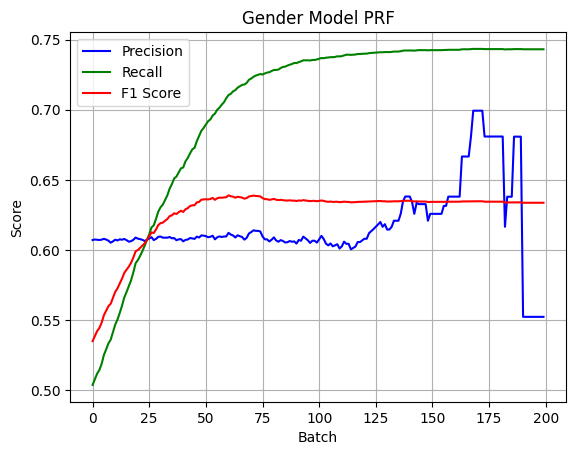

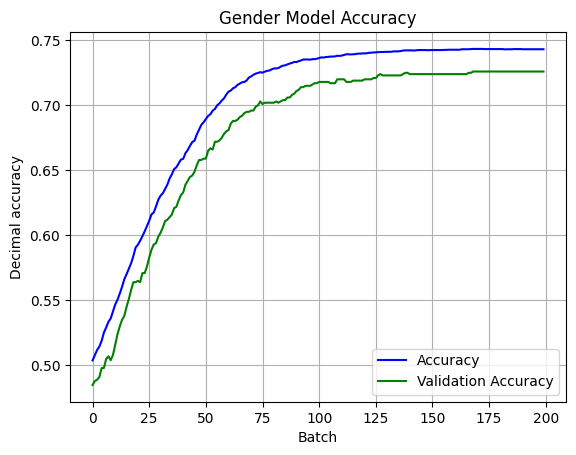

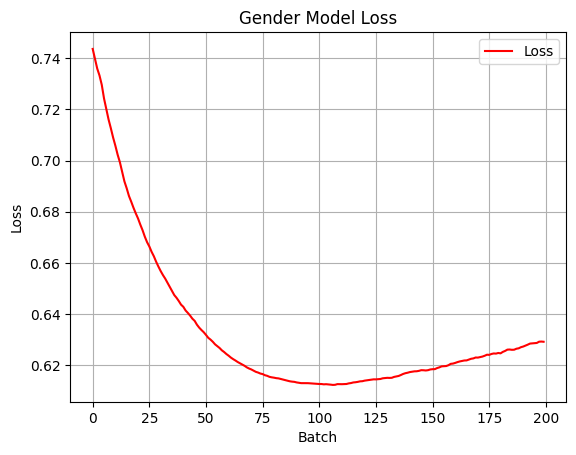

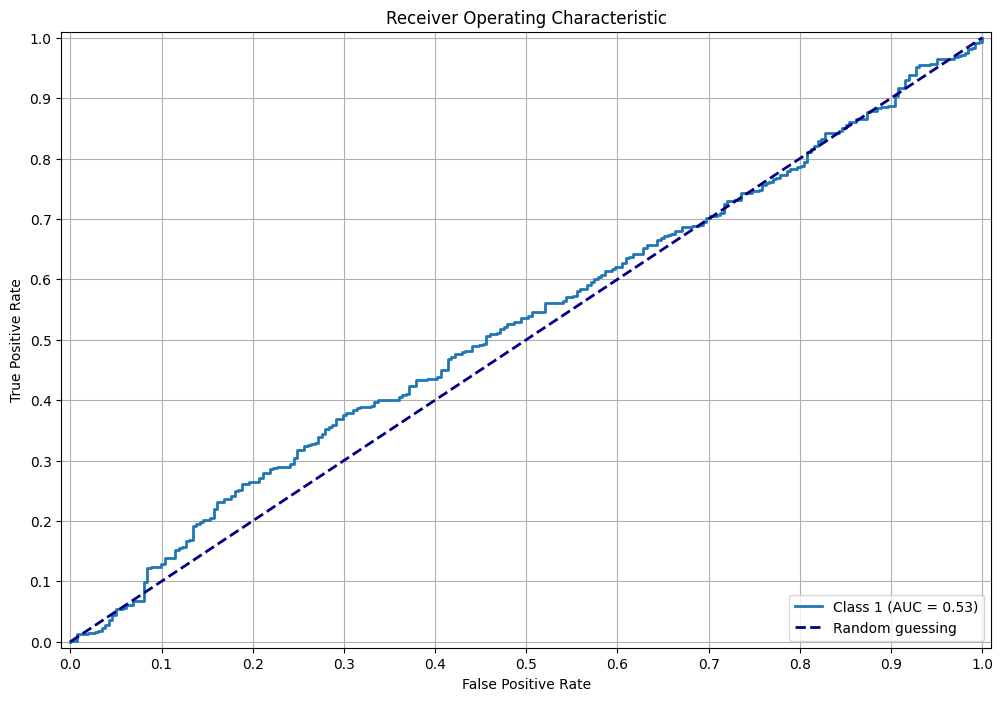

In [604]:


# Differential Privacy
if(APPLY_DP_TO_BASE_INPUT == True):
    x_train = apply_dp(x_train)
    x_val = apply_dp(x_val)
    x_test = apply_dp(x_test)

target_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))

model = define_model(x_train.shape[1], target_classes)

# Create an ART TensorFlow classifier
classifier = create_classifier(model, target_classes, x_train.shape[1])

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)


# Convert binary labels to one-hot encoding
if(target_classes==2):
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=target_classes)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=target_classes)

# Create data stream
data_stream = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train))

# Train the classifier on the data stream
metrics = train_classifier(classifier, data_stream, x_train_scaled, y_train, x_val_scaled, y_val)

# plot ROC curve
y_pred = classifier.predict(x_test_scaled)
# Convert predicted probabilities to class labels
y_pred_class = np.argmax(y_pred, axis=1)

if(PLOT_METRICS):
    plot_metrics(metrics)
    
plot_roc_curve(y_test, y_pred, target_classes)

## Attribute inference attacks

### Attack data preparation

This code is common between both whitebox and blackbox attack, so must be run in both cases

In [605]:
# Split the original training data
ATTACK_TEST_SPLIT_index = int(len(x_train) * ATTACK_TEST_SPLIT)

x_train_attack = x_train[:ATTACK_TEST_SPLIT_index]
y_train_attack = y_train[:ATTACK_TEST_SPLIT_index]

x_test_attack = x_train[ATTACK_TEST_SPLIT_index:]
y_test_attack = y_train[ATTACK_TEST_SPLIT_index:]

if(ATTACK_TARGET_FEATURE == TARGET_FEATURE):
    raise ValueError(f"ATTACK_TARGET_FEATURE: {ATTACK_TARGET_FEATURE} must be different from TARGET_FEATURE: {TARGET_FEATURE}")

# get index of attack target feature
attack_feature_index = x_df.columns.get_loc(ATTACK_TARGET_FEATURE)

# get original model's predictions
base_predictions = np.array([np.argmax(arr) for arr in classifier.predict(x_test_attack)]).reshape(-1,1)

# remove attack target feature
x_test_attack_feature = x_test_attack[:, attack_feature_index].copy().reshape(-1, 1)
x_train_attack_feature = x_train_attack[:, attack_feature_index].copy().reshape(-1, 1)
# x_test_attack = np.delete(x_test_attack, attack_feature_index, 1)
x_test_attack_wo_feature = np.delete(x_test_attack, attack_feature_index, 1)


# get each unique class of target feature
attack_feature_values = np.unique(x_test_attack_feature).tolist()

### Blackbox attack

In [606]:
# training the attack model
bb_attack = AttributeInferenceBlackBox(classifier, attack_feature = attack_feature_index)
bb_attack.fit(x_train_attack)

c:\Users\marci\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


##### Evaluate Blackbox against baseline

In [607]:
def print_attack_metrics(x_test_attack_feature, inferred_values, true_values, model_name):
    metrics = calculate_metrics(np.around(x_test_attack_feature, decimals=SIGNIFICANT_FIGURES).reshape(1,-1)[0], inferred_values)
    entropy_value = calculate_entropy(inferred_values)
    mutual_info = calculate_mutual_info(true_values, inferred_values)
    print(f'\n{model_name} metrics:')
    for metric, value in metrics.items():
        if metric in BASE_METRICS and value is not None:
            print(f'{metric}: {value:.{SIGNIFICANT_FIGURES}f}')
    print(f'Entropy: {entropy_value:.{SIGNIFICANT_FIGURES}f}')
    print(f'Mutual Information: {mutual_info:.{SIGNIFICANT_FIGURES}f}')

In [608]:
# Differential Privacy
if (APPLY_DP_TO_BB_INPUT == True):
    x_test_attack_wo_feature = apply_dp(x_test_attack_wo_feature)

if(APPLY_DP_TO_BASE_PREDICTIONS == True):
    base_predictions = apply_dp(base_predictions)

# Generate BB predictions
inferred_train_bb = bb_attack.infer(x_test_attack_wo_feature, pred=base_predictions, values=attack_feature_values)

# Compare BB with Baseline model
baseline_attack = AttributeInferenceBaseline(attack_feature=attack_feature_index)
baseline_attack.fit(x_train_attack)
inferred_train_baseline = baseline_attack.infer(x_test_attack_wo_feature, values=attack_feature_values)

print_attack_metrics(x_test_attack_feature.flatten(), inferred_train_bb, x_test_attack_feature.flatten(), 'Blackbox')
print_attack_metrics(x_test_attack_feature.flatten(), inferred_train_baseline, x_test_attack_feature.flatten(), 'Baseline')


Blackbox metrics:
accuracy: 0.0328
precision: 0.5756
recall: 0.0328
f1_score: 0.0035
Entropy: 0.0765
Mutual Information: 0.0056

Baseline metrics:
accuracy: 0.0338
precision: 0.6360
recall: 0.0338
f1_score: 0.0036
Entropy: 0.0493
Mutual Information: 0.0053


### Whitebox attack

This is an unsuccessful attempt to use the model gradients of the base model for a WhiteBox attribute inference attack 

In [609]:
# Print the summary of the model
model.summary()

# Access the layers of the model
for layer in model.layers:
    print("Layer name: ", layer.name)
    print("Weights: ", layer.get_weights())

# Define a function to calculate gradients
def calculate_gradients(model, inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        outputs = model(inputs)
    return tape.gradient(outputs, inputs)

# Calculate gradients for the attack test data
# gradients = calculate_gradients(model, tf.convert_to_tensor(x_test_attack_wo_feature, dtype=tf.float32))

# inferred_train_wb = np.mean(gradients, axis=1)

# Calculate and print the metrics for the inferred values
# print_attack_metrics(x_test_attack_feature.flatten(), inferred_train_wb, x_test_attack_feature.flatten(), 'Whitebox')

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 96)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,596 (10.14 KB)

 Trainable params: 2,594 (10.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Layer name:  dense_46
Weights:  [array([[-0.18601333, -0.02118014,  0.11738934, ...,  0.19853182,
         0.06801645,  0.12912926],
       [ 0.20166922,  0.09249867, -0.03669817, ...,  0.07524995,
         0.03978478, -0.21877435],
       [ 0.1453772 ,  0.18303578,  0.12565123, ..., -0.19363049,
        -0.19252352,  0.0289302 ],
       ...,
       [ 0.06427576, -0.21734445, -0.17607242, ..., -0.00968701,
         0.15366958, -0.08443419],
       [-0.10208135, -0.19397347,  0.00741494, ..., -0.04158229,
        -0.00942635,  0.18194917],
       [ 0.2004929 ,  0.05108567,  0.0249799 , ...,  0.12268677,
        -0.16094196,  0.1714383 ]], dtype=float32), array([-6.71937037e-03, -6.09202823e-03, -2.02013385e-02, -3.77238495e-03,
        2.55235541e-03,  1.87443453e-03, -1.92993283e-02,  2.57669352e-02,
       -8.48439615e-03,  9.15055256e-03,  5.34246396e-03, -1.62094235e-02,
        7.80092878e-03, -9.27402265e-03,  1.20791905e-02,  2.08377298e-02,
        7.86371715e-03,  1.66804506e-0